In [9]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import shapely.geometry
import numpy as np
import json
from affine import Affine
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling


In [10]:
# bbox_geojson for the CedarLakes AOI


# bbox_geojson = {
#     "type": "Polygon",
#     "coordinates": [
#         [
#             [-95.514107383931105, 28.837294991608498],
#             [-95.542191067157702, 28.82310160914],
#             [-95.533023536824004, 28.807894014576299],
#             [-95.5039012207138, 28.822751403692301], 
#             [-95.514107383931105, 28.837294991608498]
#         ]
#     ]
# }



# bbox_geojson for the CedarLakes Dune Part AOI
bbox_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [-95.506891,28.826835],
            [-95.503908,28.822756],
            [-95.53272,28.80838],
            [-95.535127,28.812163],
            [-95.506891,28.826835]
        ]
    ]
}


In [11]:
def clip_raster(filepath, bbox_geojson):
    bbox_geom = gpd.GeoDataFrame.from_features([{'type': 'Feature', 'properties': {}, 'geometry': bbox_geojson}], crs='EPSG:4326')
    with rasterio.open(filepath) as src:
        src_crs = src.crs if src.crs else 'EPSG:4326'
        bbox_geom = bbox_geom.to_crs(crs=src_crs)
        intersection = bbox_geom.unary_union.intersection(shapely.geometry.box(*src.bounds))
        if not intersection.is_empty:
            out_image, out_transform = mask(src, shapes=[intersection], crop=True)
            out_image[out_image < -1000] = np.nan
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
                "nodata": np.nan
            })
            return out_image, out_transform, out_meta
    return None, None, None

In [12]:
def rotate_image(image, transform, meta, angle, shift_x=0, shift_y=0, adj_width=0, adj_height=0):

    src_transform = transform
    rotate = Affine.rotation(angle)
    trans_x = Affine.translation(shift_x, 0)
    trans_y = Affine.translation(0, -shift_y)
    dst_transform = src_transform * rotate * trans_x * trans_y
    
    y, x = image.shape[1:]
    dst_height = int(y + adj_height)
    dst_width = int(x + adj_width)
    
    dst_image = np.empty(shape=(image.shape[0], dst_height, dst_width), dtype=image.dtype)

    meta.update({
        "transform": dst_transform,
        "height": dst_height,
        "width": dst_width,
        "nodata": np.nan,
    })
    
    reproject(
        source=image,
        destination=dst_image,
        src_transform=src_transform,
        dst_transform=dst_transform,
        src_crs=meta['crs'],
        dst_crs=meta['crs'],
        resampling=Resampling.nearest,
        src_nodata=meta.get('nodata'),
        dst_nodata=np.nan
    )
    
    # Find the bounding box where data exists
    valid_data_positions = np.where(~np.isnan(dst_image))
    ymin, xmin = valid_data_positions[1].min(), valid_data_positions[2].min()
    ymax, xmax = valid_data_positions[1].max(), valid_data_positions[2].max()
    
    # Clip the image to the bounding box
    dst_image_clipped = dst_image[:, ymin:ymax+1, xmin:xmax+1]
    plt.imshow(dst_image_clipped[0], cmap='gray')
    plt.title("Rotated and Clipped Image")
    plt.show()
    
    # Update metadata for the clipped image
    new_height, new_width = dst_image_clipped.shape[1], dst_image_clipped.shape[2]
    new_transform = dst_transform * Affine.translation(xmin, ymin)
    meta.update({
        "transform": new_transform,
        "height": new_height,
        "width": new_width,
    })
    
    return dst_image_clipped, new_transform, meta


In [22]:
def analyze_raster(image, transform, output_geojson_path):
    geojson_features = []
    band1 = image[0]  # Assuming single band
    for x in range(band1.shape[1]):
        if np.all(np.isnan(band1[:, x])):
            continue 
        max_value = np.nanmax(band1[:, x])
        y = np.nanargmax(band1[:, x])
        if max_value <= 0 :
            continue
        
        lon, lat = transform * (x, y)
        feature = {
            "type": "Feature",
            "properties": {"elevation": float(max_value)},
            "geometry": {
                "type": "Point",
                "coordinates": [lon, lat]
            }
        }
        geojson_features.append(feature)

    if geojson_features:
        geojson_data = {
            "type": "FeatureCollection",
            "features": geojson_features,
            "crs": {
                "type": "name",
                "properties": {
                    "name": "urn:ogc:def:crs:EPSG::32139"
                }
            }
        }
        with open(output_geojson_path, 'w') as f:
            json.dump(geojson_data, f)


In [23]:
def process_raster(filepath, bbox_geojson, angle, shift_x, shift_y, adj_width, adj_height, output_geojson_path):
    image, transform, meta = clip_raster(filepath, bbox_geojson)
    if image is not None:
        image, transform, meta = rotate_image(image, transform, meta, angle, shift_x, shift_y, adj_width, adj_height)
        global zz 
        zz = image
        analyze_raster(image, transform, output_geojson_path)



In [24]:


rasters_dict = {
    'Clipped(2001)_meter.tif': 'DEM 2001',
    'Clipped(2002)_meter.tif': 'DEM 2002',
    'Clipped(2006)_meter.tif': 'DEM 2006',
    'Clipped(2009)_meter.tif': 'DEM 2009',
    'Clipped(2016)_meter.tif': 'DEM 2016',
    'Clipped(2018)_meter.tif': 'DEM 2018',
    '(Clipped)2018_19_post_harvey_meter.tif': 'DEM 2018_19_post_harvey'
}



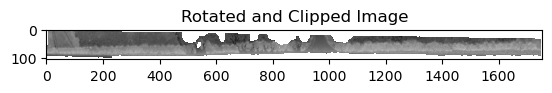

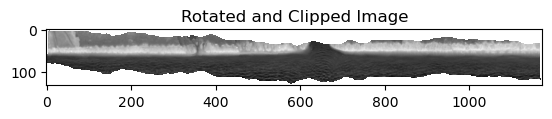

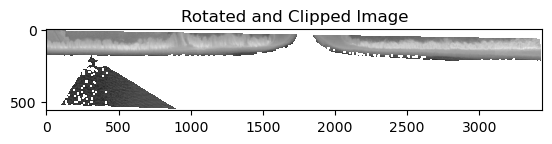

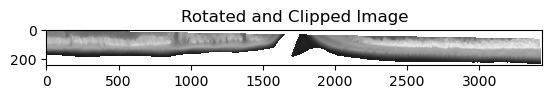

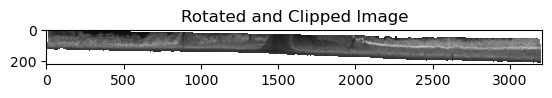

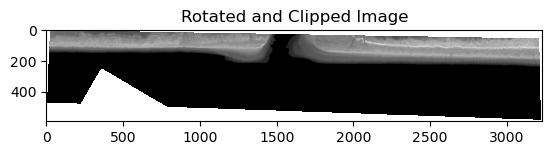

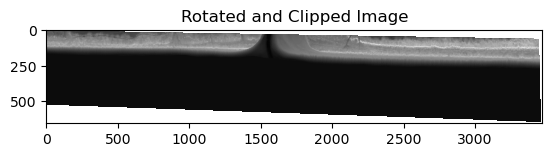

In [25]:

for in_file, dem_year in rasters_dict.items():
    output_geojson_path = f"max_elevations_{dem_year.replace(' ', '_')}.geojson"
    process_raster(in_file, bbox_geojson, angle=-34, shift_x=-1000, shift_y=0, adj_width=2000, adj_height=500, output_geojson_path=output_geojson_path)